In [1]:
#IMPORT LIBRARIES
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import keras_tuner as kt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

from keras import backend as K

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.6.2


In [2]:
#LOAD TRAINING DATA
dataset = pd.read_csv('../input/timeseries/Training.csv')

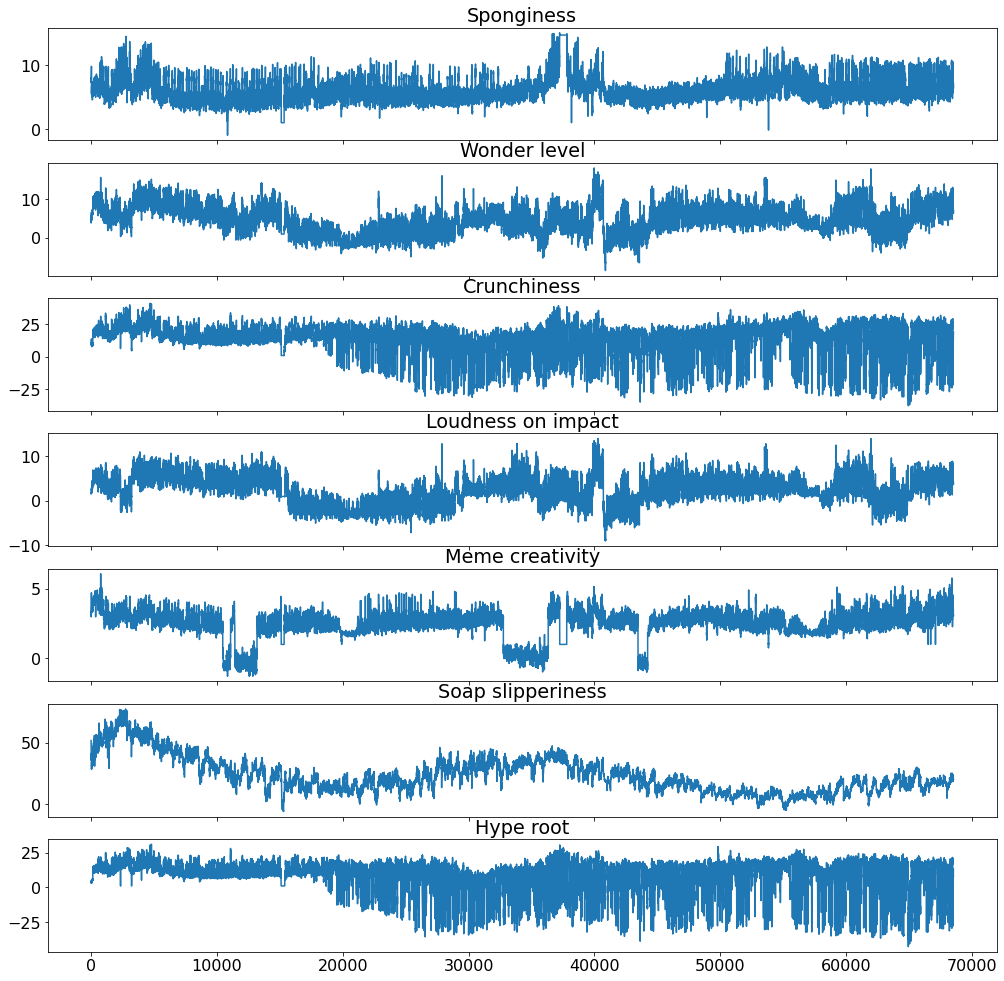

In [3]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

(58249, 7) (10279, 7)


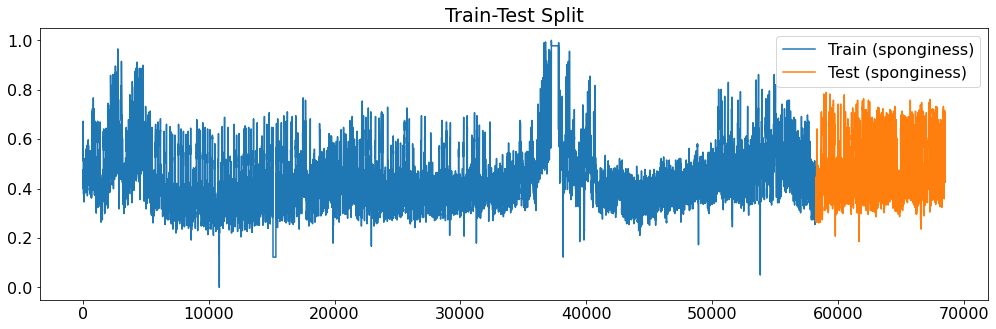

In [4]:
test_size = int(dataset.shape[0]*0.15)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [5]:
#MULTIVARIATE FORECASTING
target_labels = dataset.columns
stride = 16
telescope = 864
window = int(telescope * 1.5)

In [6]:
def build_sequences(df, target_labels, window, stride, telescope):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [7]:
batch_size = 64
epochs = 200

units = 200

In [8]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [9]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]

In [10]:
def hypermodel(hp):
    
    model = tfk.Sequential()
    model.add(tfkl.Input(shape=input_shape, name='Input'))
    model.add(tfkl.LSTM(hp.Choice('units1', values = [80,108,150,192]),dropout = hp.Choice('drop1',values = [0.0,.2]),return_sequences = True))
    model.add(tfkl.LSTM(hp.Choice('units2', values = [88,128,160,214]), dropout = hp.Choice('drop2',values = [0.0,.2])))
    model.add(tfkl.LayerNormalization())
    model.add(tfkl.Dense(output_shape[-1]*output_shape[-2], activation='selu'))
    model.add(tfkl.Reshape((output_shape[-2],output_shape[-1])))
    model.add(tfkl.Conv1D(output_shape[-1], 1, padding='same'))
    model.compile(loss=root_mean_squared_error, optimizer=tfk.optimizers.Adam(), metrics='mse')
    return model

In [11]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3510, 1296, 7), (3510, 864, 7), (513, 1296, 7), (513, 864, 7))

In [12]:
tuner = kt.RandomSearch(hypermodel,
                        objective='val_mse',
                        directory='tuning', 
                        max_trials = 25,
                        project_name='neurons-dropout-activation')
print('ok')

2022-01-01 11:53:03.996375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 11:53:04.082892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 11:53:04.083691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-01 11:53:04.085230: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

ok


In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Choice)
{'default': 80, 'conditions': [], 'values': [80, 108, 150, 192], 'ordered': True}
drop1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units2 (Choice)
{'default': 88, 'conditions': [], 'values': [88, 128, 160, 214], 'ordered': True}
drop2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}


In [14]:
tuner.search(X_train, y_train,   
            epochs = 20,
            batch_size=64,
            validation_data = (X_test, y_test))

Trial 25 Complete [00h 03m 25s]
val_mse: 0.01291769277304411

Best val_mse So Far: 0.012057113461196423
Total elapsed time: 01h 22m 13s


In [15]:
models = tuner.get_best_models(num_models=4)

In [16]:
tuner.results_summary()

Results summary
Results in tuning/neurons-dropout-activation
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
units1: 108
drop1: 0.2
units2: 128
drop2: 0.2
Score: 0.012057113461196423
Trial summary
Hyperparameters:
units1: 192
drop1: 0.0
units2: 160
drop2: 0.2
Score: 0.012082812376320362
Trial summary
Hyperparameters:
units1: 150
drop1: 0.2
units2: 88
drop2: 0.2
Score: 0.01212078332901001
Trial summary
Hyperparameters:
units1: 80
drop1: 0.0
units2: 88
drop2: 0.2
Score: 0.012129317037761211
Trial summary
Hyperparameters:
units1: 80
drop1: 0.0
units2: 214
drop2: 0.2
Score: 0.012198357842862606
Trial summary
Hyperparameters:
units1: 108
drop1: 0.2
units2: 214
drop2: 0.2
Score: 0.012235553935170174
Trial summary
Hyperparameters:
units1: 108
drop1: 0.2
units2: 160
drop2: 0.2
Score: 0.012389452196657658
Trial summary
Hyperparameters:
units1: 192
drop1: 0.0
units2: 88
drop2: 0.0
Score: 0.012405588291585445
Trial summary
Hyperparameters:
units1: 